**데이터 로드 및 전처리** 
* reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리
* 데이터셋은 keras.datasets에서 불러올 수 있는 reuters 데이터 셋을 활용
* 파라메터 조정을 통해 단어의 개수는 10000개로 제한합니다(num_words=10000).
* 데이터셋 분리 작업에서는 sklearn 라이브러리의 train_test_split 함수를 활용
* 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from keras.datasets import reuters

In [11]:
# 문제 2-1: reuters 데이터셋을 로드하고, 훈련 데이터셋에서 25%를 검증 데이터셋으로 분리합니다.

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=2023)


# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇 개인지 출력합니다.
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(len(set(train_labels)))

6736
2246
2246
46


* 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행.
* 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환

In [12]:
# 문제 2-2: 텍스트 데이터의 전처리를 위해서 각 데이터셋마다 원-핫 인코딩을 수행합니다.
def one_hot_encoding(data, dim=10000):
    results = np.zeros((len(data), dim))
    for i, d in enumerate(data):
        results[i, d] = 1.
    return results

x_train = one_hot_encoding(train_data)
x_val = one_hot_encoding(val_data)
x_test = one_hot_encoding(test_data)

# 레이블 데이터들은 범주형 형태로 to_categorical() 함수를 사용해 변환합니다.
y_train = utils.to_categorical(train_labels)
y_val = utils.to_categorical(val_labels)
y_test = utils.to_categorical(test_labels)

print(x_train[15])
print(x_val[15])
print(x_test[15])
print(y_train[15])
print(y_val[15])
print(y_test[15])

[0. 1. 0. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 1. 1. ... 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


**모델 구성 및 컴파일**

* BatchNormalization과 Dropout을 적용하여 빠르게 학습하면서 과대적합을 방지
* 46개의 뉴스 주제를 분류하는 딥러닝 모델을 구성





In [20]:
# 문제 2-3: 빠른 학습과 과대적합을 방지하기 위해 BatchNormalization과 Dropout을 적용한 딥러닝 모델을 구성합니다.

model = models.Sequential()
model.add(layers.Input(shape=(10000, )))
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu')) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu')) 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(46, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', metrics=['accuracy'])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                640064    
                                                                 
 batch_normalization_6 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 activation_6 (Activation)   (None, 64)                0         
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 batch_normalization_7 (Bat  (None, 64)                256       
 chNormalization)                                     

**모델 학습**
*ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.

In [21]:
# 문제 2-4: ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행합니다.
check_point_cb = callbacks.ModelCheckpoint('Reuters_model.h5', 
                                           save_best_only=True)
early_stopping_cb = callbacks.EarlyStopping(patience=10, 
                                            monitor='val_loss',
                                            restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60,
                    validation_data=(x_val, y_val),
                    callbacks=[check_point_cb, early_stopping_cb])

Epoch 1/60
211/211 [==============================] - 2s 7ms/step - loss: 2.1158 - accuracy: 0.5145 - val_loss: 1.6132 - val_accuracy: 0.6946
Epoch 2/60
 29/211 [===>..........................] - ETA: 1s - loss: 1.5557 - accuracy: 0.6261

C:\Users\sunw0506\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


211/211 [==============================] - 1s 6ms/step - loss: 1.5310 - accuracy: 0.6357 - val_loss: 1.2853 - val_accuracy: 0.7182
Epoch 3/60
211/211 [==============================] - 1s 6ms/step - loss: 1.3482 - accuracy: 0.6780 - val_loss: 1.2381 - val_accuracy: 0.7280
Epoch 4/60
211/211 [==============================] - 1s 6ms/step - loss: 1.2253 - accuracy: 0.7046 - val_loss: 1.2026 - val_accuracy: 0.7507
Epoch 5/60
211/211 [==============================] - 1s 6ms/step - loss: 1.1660 - accuracy: 0.7231 - val_loss: 1.1867 - val_accuracy: 0.7573
Epoch 6/60
211/211 [==============================] - 1s 6ms/step - loss: 1.0970 - accuracy: 0.7389 - val_loss: 1.1672 - val_accuracy: 0.7649
Epoch 7/60
211/211 [==============================] - 1s 6ms/step - loss: 1.0274 - accuracy: 0.7564 - val_loss: 1.1827 - val_accuracy: 0.7680
Epoch 8/60
211/211 [==============================] - 1s 6ms/step - loss: 0.9984 - accuracy: 0.7634 - val_loss: 1.1916 - val_accuracy: 0.7738
Epoch 9/60
211/21

C:\Users\sunw0506\AppData\Local\Temp\ipykernel_11880\2054681030.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


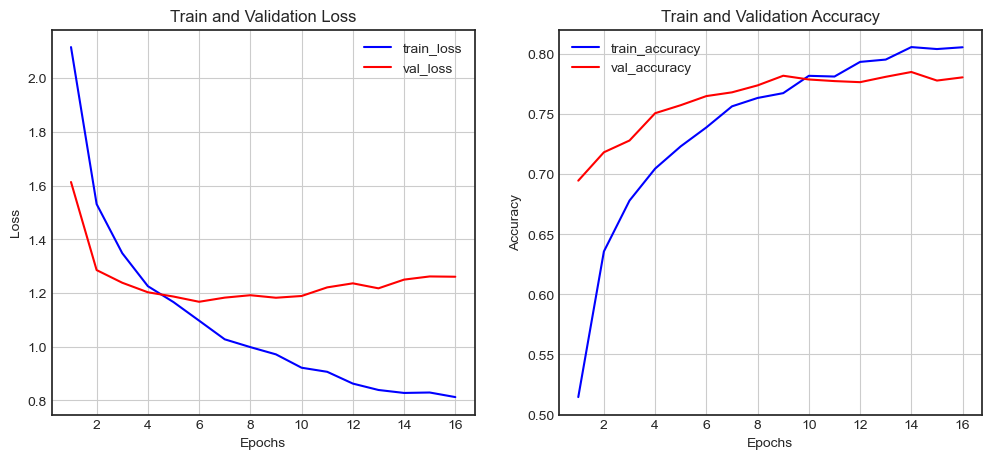

In [22]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화합니다.
plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()





**모델 평가 및 예측**


In [16]:
# 문제 2-5: 테스트 데이터셋을 이용해 모델을 평가합니다.
model.evaluate(x_test, y_test)

71/71 [==============================] - 0s 3ms/step - loss: 0.8968 - accuracy: 0.8108


[0.8967916965484619, 0.8107746839523315]